<a href="https://colab.research.google.com/github/saman-nia/AIRMA-Time-Forecasting-with-R/blob/master/Deep%20Learning%20Dimensionality%20Reduction%20for%20Text%20(3NG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Saman Paidar Nia

In [0]:
# Import libraries.
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
#-----------------------------------------------------------
import numpy
import matplotlib.pyplot as plt
import warnings
import math
import sys
import logging
import scipy
#-----------------------------------------------------------
from scipy.spatial.distance import squareform, pdist
from optparse import OptionParser
from math import sqrt
from tqdm import tqdm
from IPython.display import clear_output
#------------------------------------------------------------
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn.metrics import normalized_mutual_info_score
warnings.filterwarnings('ignore')

In [0]:
# Compute pairwise distances between observations in n-dimensional space.
class Similarity_Graph:
  def get_matrix(self, data, similar_method):
    X = preprocessing.normalize(data, norm='l2', axis=0)
    X = squareform(pdist(X, str(similar_method)))
    return X

In [0]:
class Similarity_Dataset_Iterator():
  def __init__(self, data, labels, similarity, similarity_method):
    self.data = data
    self.labels = labels
    self.similarity_method = similarity_method
    self.matrix = Similarity_Graph.get_matrix(self, data=self.data, similar_method=self.similarity_method)
    self.data_size = self.matrix.shape[0]
    self.current_index = 0
  def next_batch(self, num):
    data=self.matrix.transpose()
    labels=self.labels
    idx = numpy.arange(0, len(data))
    numpy.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]
    return data_shuffle, labels_shuffle
  def whole_dataset(self):
    return (self.matrix.transpose(), self.labels)

In [0]:
#  Load the 20 newsgroups dataset and transform it into tf-idf vectors.
def read_NewsGroup_data(similarity, similarity_method, categories_NG, n_samples):    
    if type(categories_NG) == list and not categories_NG:
      categories_NG = ['comp.graphics','rec.sport.baseball','talk.politics.guns']
    elif type(categories_NG) != list:
      categories_NG = None
    dataset = fetch_20newsgroups(subset='train',categories=categories_NG,shuffle=True,random_state=42)
    if n_samples == 'all' or n_samples <= 0:
      labels = dataset.target
      true_k = numpy.unique(labels).shape[0]
      vectorizer = TfidfVectorizer(max_df=0.5,min_df=2, stop_words='english')
      X = vectorizer.fit_transform(dataset.data)
    else:
      labels = dataset.target[:n_samples]
      true_k = numpy.unique(labels).shape[0]
      vectorizer = TfidfVectorizer(max_df=0.5,min_df=2, stop_words='english')
      X = vectorizer.fit_transform(dataset.data[:n_samples])      
    return (X.toarray(), categories_NG,
            Similarity_Dataset_Iterator(X.toarray(), labels, similarity, similarity_method))

In [0]:
list_20groups = ['alt.atheism','comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware',
                 'comp.windows.x','misc.forsale','rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey','sci.crypt',
                 'sci.electronics','sci.med','sci.space','soc.religion.christian','talk.politics.guns','talk.politics.mideast',
                 'talk.politics.misc','talk.religion.misc']

In [0]:
def list_groups():
  for jj in range(len(list_20groups)):
    print('{:d} : {}'.format(jj+1, list_20groups[jj]))
  print('\n')

In [7]:
list_groups()
categories_NG = []
n_groups = 0
count_run = False
while True:
  if count_run == False:
    count_run = True
    category = input('Please insert one by one number of your desired group from the list above:\n'
                     'e.g. type: 1, then press enter.\n'                     
                     '***The form again shows up and wating for the next insert***\n'
                     '***whenever you done, just press the enter without inserting value***\n'                   
                     '***Another valid values: << all >> for all 20 groups, <<6NG>> for 6 default groups, blank value for 3 default groups***\n'
                     'Enter here: ')
  else:
    category = input()
  try:
    category = int(category)
    if 1 <= category <= 20:
      n_groups += 1
      category = category - 1
      categories_NG.append(list_20groups[category])
      print('Please insert next number of your desired group from the list above:\n'
            'Enter here: ')
    else:
      print('Please insert number between 1 to 20 ...')      
  except ValueError:
    if category == '' and n_groups == 0:
      categories_NG = []
      n_groups = 3
      print('You selected 3 default groups.')
      break
    elif category == '' and n_groups > 0:
      print('You selected {:d} groups.'.format(n_groups))
      break
    elif category == 'all':
      categories_NG = None
      n_groups = 20
      print('You selected all 20 newsgroups.')
      break
    elif category == '6NG' or category == '6ng':
      categories_NG = ['soc.religion.christian','talk.politics.guns','comp.graphics','talk.politics.mideast','sci.crypt','rec.sport.hockey']
      n_groups = 6
      print('You selected 6 newsgroups.')
      break
    else:
      print('Please insert valid value!!!')

1 : alt.atheism
2 : comp.graphics
3 : comp.os.ms-windows.misc
4 : comp.sys.ibm.pc.hardware
5 : comp.sys.mac.hardware
6 : comp.windows.x
7 : misc.forsale
8 : rec.autos
9 : rec.motorcycles
10 : rec.sport.baseball
11 : rec.sport.hockey
12 : sci.crypt
13 : sci.electronics
14 : sci.med
15 : sci.space
16 : soc.religion.christian
17 : talk.politics.guns
18 : talk.politics.mideast
19 : talk.politics.misc
20 : talk.religion.misc


Please insert one by one number of your desired group from the list above:
e.g. type: 1, then press enter.
***The form again shows up and wating for the next insert***
***whenever you done, just press the enter without inserting value***
***Another valid values: << all >> for all 20 groups, <<6NG>> for 6 default groups, blank value for 3 default groups***
Enter here: 
You selected 3 default groups.


In [8]:
while True:
  n_samples = input('Please enter the number of samples:\n'
                    '*** Any invalid input or leave the input without value, will be considered as 200 samples for each group***\n'
                    'Enter here: ')
  try:    
    n_samples = int(n_samples)*n_groups
    print("You selected {:d} samples from all selected groups.".format(n_samples))
    break
  except ValueError:
    if n_samples == 'all' or n_samples == 'ALL':
      n_samples = 'all'
      print("You selected All samples of each group.")
      break      
    else:
      n_samples = 200 * n_groups
      print("You selected {:d} samples from all selected groups.".format(n_samples))
      break
      

Please enter the number of samples:
*** Any invalid input or leave the input without value, will be considered as 200 samples for each group***
Enter here: 
You selected 600 samples from all selected groups.


In [0]:
similarity_methods = ['cosine','correlation','euclidean','sqeuclidean','mahalanobis','chebyshev','canberra','braycurtis','cityblock']

In [0]:
def list_similarity_methods():
  for jjj in range(len(similarity_methods)):
    print('{:d} : {}'.format(jjj+1, similarity_methods[jjj]))
  print('\n')

In [11]:
list_similarity_methods()
while True:
  similarity_ = input('Please insert code of your desired similarity distance measurment from the list above:\n'
                    'e.g. type: 1, then press enter.\n'                     
                    '***Blank value for Correlation Distance.***\n'
                    'Enter here: ')
  try:
    similarity_ = int(similarity_)
    if 1 <= similarity_ <= len(similarity_methods):
      similarity_method = similarity_methods[similarity_-1]
      print('You selected: ', similarity_method)
      break
    else:
      print('Please insert number between 1 to 9 ...')      
  except ValueError:
    similarity_method = 'correlation'
    print('You selected: ', similarity_method)
    break

1 : cosine
2 : correlation
3 : euclidean
4 : sqeuclidean
5 : mahalanobis
6 : chebyshev
7 : canberra
8 : braycurtis
9 : cityblock


Please insert code of your desired similarity distance measurment from the list above:
e.g. type: 1, then press enter.
***Blank value for Correlation Distance.***
Enter here: 
You selected:  correlation


In [0]:
orig_data_set, categories_lables, train_set = read_NewsGroup_data(Similarity_Graph(), similarity_method, categories_NG, n_samples)

In [13]:
n_input = train_set.data_size 
print('Number of Sample are: ', n_input)

Number of Sample are:  600


In [0]:
def find_geometric_value():
  geometric_value = 2
  while n_input > geometric_value:
    geometric_value = geometric_value * 2
  geometric_value = geometric_value / 2
  return int(geometric_value)

In [0]:
def find_max_layers(embedded_node):    
  if embedded_node is None:
    embedded_node = int(2)
  next_layer = find_geometric_value()
  count_layers = 0
  while next_layer >= embedded_node:
    count_layers += 1
    next_layer = next_layer / 2
  max_layers = count_layers - 1
  print ('The embedded goal of dimension is:------------------------- ', embedded_node)
  print ('The maximum possibility of having of hiedden layers is:---- ', max_layers)
  print ('Number of nodes in the first hidden layer is:-------------- ', find_geometric_value())
  return str(embedded_node), max_layers, find_geometric_value()

In [16]:
while True:
  value = input('Please Enter your Final Dimension and press Enter:\n'
                'Valid range, please: From 2 onwards\n'
                'Any invalid input, will be considered as 2\n')
  try:
    value = int(value)
    break
  except ValueError:
    value = 2
    break
n_code, n_max_layers, first_layer = find_max_layers(embedded_node = value)

Please Enter your Final Dimension and press Enter:
Valid range, please: From 2 onwards
Any invalid input, will be considered as 2

The embedded goal of dimension is:-------------------------  2
The maximum possibility of having of hiedden layers is:----  8
Number of nodes in the first hidden layer is:--------------  512


In [0]:
n_hidden_layer = [first_layer]
geometric_progress = first_layer
for i in range(1, n_max_layers):
  geometric_progress = int(geometric_progress / 2)
  n_hidden_layer.append(geometric_progress )

In [0]:
def get_hidden_layer(num_hidden = n_max_layers):
  if num_hidden is None:
    num_hidden = int(n_max_layers)
  num_nodes = n_input+sum(n_hidden_layer[:num_hidden])+int(n_code)
  print("Graph Encoder looks like this:")
  print("Input:--------------------->:",n_input)
  print("Hidden Layers are:--------->:",n_hidden_layer[:num_hidden])
  print("Embedded Goal-------------->:",n_code)
  print("Number of Hidden Layers:--->:",num_hidden)
  print("Number of Layers:---------->:",len(n_hidden_layer[:num_hidden])+2)
  print("Number of Nodes:----------->:",num_nodes)
  print("Number of Groups:---------->:",n_groups)
  return n_hidden_layer[:num_hidden], num_nodes

In [19]:
run_ghl = False
while True:  
  if run_ghl == False:
    value_hl = input('Please Enter the number of hidden layers and press Enter:\n'
                      'Valid range, please: From 1 to {:d} \n'
                       'Any invalid input, will be considered as {:d} \n'.format(n_max_layers, int(sqrt(n_max_layers))))
    run_ghl = True
  else:
    value_hl = input()
  try:
    if (1 <= int(value_hl) <= n_max_layers):
      value_hl = int(value_hl)
      break
    else:
      print('Please insert valid value or press enter without value:')
  except ValueError:
    value_hl = int(sqrt(n_max_layers))
    break
num_hidden_layers, num_nodes = get_hidden_layer(num_hidden = value_hl)

Please Enter the number of hidden layers and press Enter:
Valid range, please: From 1 to 8 
Any invalid input, will be considered as 2 

Graph Encoder looks like this:
Input:--------------------->: 600
Hidden Layers are:--------->: [512, 256]
Embedded Goal-------------->: 2
Number of Hidden Layers:--->: 2
Number of Layers:---------->: 4
Number of Nodes:----------->: 1370
Number of Groups:---------->: 3


In [0]:
scope_layer = []
for i in range(1, len(num_hidden_layers)+1):
  new_word = "hidden-layer-"
  character = str(i)
  new_word += character
  scope_layer.append(new_word)

In [0]:
def batch_norm(x, n_out, mode_train):
    beta_initialize = tf.constant_initializer(value=0.1, dtype=tf.float32)
    gamma_initialize = tf.constant_initializer(value=1.0, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_initialize)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_initialize)
    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.5)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = control_flow_ops.cond(mode_train, mean_var, lambda: (ema_mean, ema_var))
    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-08, True)
    return tf.reshape(normed, [-1, n_out])

In [0]:
def layer(input, weight_shape, bias_shape, mode_train):
    weight_initialize = tf.random_normal_initializer(stddev = (1.0 / weight_shape[0] ** 0.5))
    bias_initialize = tf.random_normal_initializer(stddev = (1.0 / bias_shape[0] ** 0.5))
    w = tf.get_variable("w", weight_shape, initializer = weight_initialize)
    b = tf.get_variable("b", bias_shape, initializer = bias_initialize)
    return tf.nn.sigmoid(batch_norm((tf.matmul(input, w) + b), weight_shape[1], mode_train))

In [0]:
def encoder(x, n_code, mode_train):    
    with tf.variable_scope("encoder"):
      hidden = [None] * len(num_hidden_layers)
      for ii in range(len(num_hidden_layers)):
        if scope_layer[ii] == 'hidden-layer-1':
          with tf.variable_scope(scope_layer[ii]):
            hidden[ii] = layer(x, [n_input, num_hidden_layers[ii]], [num_hidden_layers[ii]], mode_train)
        else:
          with tf.variable_scope(scope_layer[ii]):
            hidden[ii] = layer(hidden[ii-1], [num_hidden_layers[ii-1], num_hidden_layers[ii]], [num_hidden_layers[ii]], mode_train)  
      with tf.variable_scope("embedded"):
        code = layer(hidden[-1], [num_hidden_layers[-1], n_code], [n_code], mode_train)
    return code

In [0]:
def decoder(code, n_code, mode_train):
    with tf.variable_scope("decoder"):
      hidden = [None] * len(num_hidden_layers)
      for ii in range(len(num_hidden_layers)):
        if scope_layer[ii] == 'hidden-layer-1':
          with tf.variable_scope(scope_layer[ii]):
            hidden[ii] = layer(code, [n_code, num_hidden_layers[-1]], [num_hidden_layers[-1]], mode_train)
        else:
          with tf.variable_scope(scope_layer[ii]):
            hidden[ii] = layer(hidden[ii-1], [num_hidden_layers[-(ii)], num_hidden_layers[-(ii+1)]], [num_hidden_layers[-(ii+1)]], mode_train)        
      with tf.variable_scope("reconstructed"):
        output = layer(hidden[-1], [num_hidden_layers[0], n_input], [n_input], mode_train)
    return output

In [0]:
def loss(reconstructed, x):
    with tf.variable_scope("train"):
      train_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(reconstructed, x)), 1))
      return train_loss

In [0]:
def training(cost, learning_rate, beta1, beta2, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon=1e-08, use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

In [0]:
def k_means(X, n_clusters):
    kmeans = cluster.KMeans(n_clusters=n_clusters, n_init=n_input, max_iter=n_input)
    return kmeans.fit(X).labels_

In [0]:
data_set, labels_set = train_set.whole_dataset() #---- Allocation of data and labels

In [0]:
# Parameters
n_layers = (value_hl + 2) #------------------------ Number of Layers.
beta1 = 0.9 #-------------------------------------- Decay rate 1.  
beta2 = 0.99 #------------------------------------- Decay rate 2
learning_rate = 0.001 #---------------------------- Learning rate.
n_batch = n_layers #------------------------------- Number of selection data in per step.
n_backpro = round(n_input/n_batch) #--------------- Number of Backpro in per epoch.
epochs = round(10000 / n_backpro) #---------------- Number of Epochs.
n_diplay = n_layers #------------------------------ Step of getting new cost and clustering result.

In [30]:
print('Number of Samples are: -------------------------->',n_input)
print('Number of epochs are: --------------------------->',epochs)
print('Number of batch sizes are: ---------------------->',n_batch)
print('Number of Backpropagation in each epoch is: ----->',n_backpro)

Number of Samples are: --------------------------> 600
Number of epochs are: ---------------------------> 67
Number of batch sizes are: ----------------------> 4
Number of Backpropagation in each epoch is: -----> 150


In [0]:
with tf.Graph().as_default():    
    with tf.variable_scope("autoencoder_architecture"):
        x = tf.placeholder("float", [None, n_input])   
        mode_train = tf.placeholder(tf.bool)
        code = encoder(x, int(n_code), mode_train)
        reconstructed = decoder(code, int(n_code), mode_train)
        cost = loss(reconstructed, x)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_optimizer = training(cost, learning_rate, beta1, beta2, global_step)
        sess = tf.Session()
        init_op = tf.global_variables_initializer()
        sess.run(init_op)

In [0]:
loss_cost=[] #------- A list to keep all training evaluations.
steps=[] #----------- A list to keep all steps.

In [33]:
# Training cycle
for epoch in tqdm(range(1, epochs+1)):
    # Fit training with Backpropagation using batch data.
    for i in range(n_backpro):
        miniData, _ = train_set.next_batch(n_batch)
        _, new_cost = sess.run([train_optimizer, cost], feed_dict={x: miniData, mode_train:True})
    #-------------------------------------------------------------------------------------------
    if epoch % n_diplay == 0 or epoch == epochs:
      steps.append(epoch)
      loss_cost.append(new_cost)

100%|██████████| 67/67 [01:41<00:00,  1.52s/it]


In [0]:
#------------------------- Save the optimized data ---------------------------------------------
ae_codes = sess.run(code, feed_dict={x: data_set, mode_train: False})
ae_reconstructed = sess.run(reconstructed, feed_dict={x: data_set, mode_train: False})
pred_KMeans_code = k_means(ae_codes, n_groups)
nmi_KMeans_code = normalized_mutual_info_score(labels_set, pred_KMeans_code)

In [0]:
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
by_hsv = ((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
          for name, color in colors.items())
sorted_color = [name for hsv, name in by_hsv]

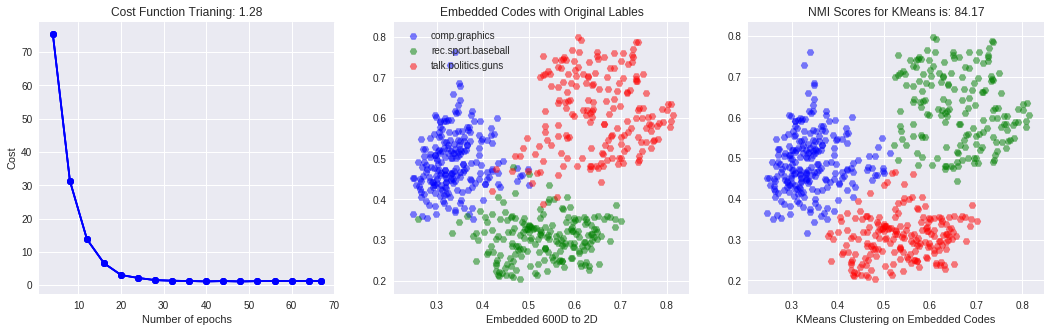

In [36]:
plt.figure(figsize=(18,5))
for num in range(n_groups):
  plt.subplot(1,3,1)
  plt.plot(steps, loss_cost, color='b', marker="o")
  plt.xlabel('Number of epochs')
  plt.ylabel('Cost')
  plt.title('Cost Function Trianing: {:0.2f}'.format(new_cost))
  plt.subplot(1,3,2)
  plt.scatter([ae_codes[:,0][i] for i in range(len(labels_set)) if labels_set[i] == num],
              [ae_codes[:,1][i] for i in range(len(labels_set)) if labels_set[i] == num],
              50, label=categories_lables[num], color = sorted_color[num], alpha=0.5, marker='H')
  plt.title('Embedded Codes with Original Lables')
  plt.xlabel('Embedded {:d}D to {:d}D'.format(n_input,int(n_code)))
  plt.legend(loc='best')
  plt.subplot(1,3,3)
  plt.scatter([ae_codes[:,0][i] for i in range(len(pred_KMeans_code)) if pred_KMeans_code[i] == num],
              [ae_codes[:,1][i] for i in range(len(pred_KMeans_code)) if pred_KMeans_code[i] == num],
              50, color = sorted_color[num], alpha=0.5, marker='H')
  plt.title(('NMI Scores for KMeans is: {:0.2f}').format(nmi_KMeans_code*100))
  plt.xlabel('KMeans Clustering on Embedded Codes')
plt.show()

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(orig_data_set)
pred_KMeans_pca = k_means(X_pca, n_groups)
nmi_KMeans_pca = normalized_mutual_info_score(labels_set, pred_KMeans_pca)

In [0]:
from sklearn.manifold import SpectralEmbedding
spec_embed = SpectralEmbedding(n_components=2)
X_spec_embed = spec_embed.fit_transform(orig_data_set)
pred_KMeans_spec_embed = k_means(X_spec_embed, n_groups)
nmi_KMeans_spec_embed = normalized_mutual_info_score(labels_set, pred_KMeans_spec_embed)

In [0]:
from sklearn.manifold import LocallyLinearEmbedding
LLE = LocallyLinearEmbedding(n_components=2)
X_LLE = LLE.fit_transform(orig_data_set)
pred_KMeans_LLE = k_means(X_LLE, n_groups)
nmi_KMeans_LLE = normalized_mutual_info_score(labels_set, pred_KMeans_LLE)

In [0]:
from sklearn.manifold import Isomap
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(orig_data_set)
pred_KMeans_isomap = k_means(X_isomap, n_groups)
nmi_KMeans_isomap = normalized_mutual_info_score(labels_set, pred_KMeans_isomap)

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(orig_data_set)
pred_KMeans_tsne = k_means(X_tsne, n_groups)
nmi_KMeans_tsne = normalized_mutual_info_score(labels_set, pred_KMeans_tsne)

In [0]:
from sklearn.decomposition import KernelPCA
KPCA = KernelPCA(n_components=2)
X_KPCA = KPCA.fit_transform(orig_data_set)
pred_KMeans_KPCA = k_means(X_KPCA, n_groups)
nmi_KMeans_KPCA = normalized_mutual_info_score(labels_set, pred_KMeans_KPCA)

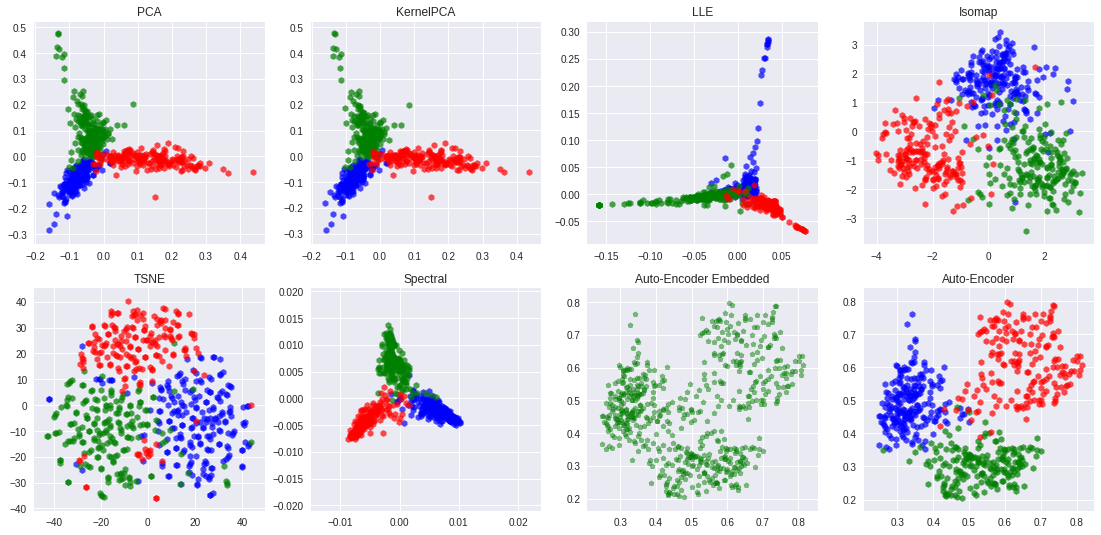

In [43]:
plt.figure(figsize=(19,9))
for num in range(n_groups):
  plt.subplot(2,4,1)  
  plt.scatter([X_pca[:,0][i] for i in range(len(labels_set)) if labels_set[i] == num],
              [X_pca[:,1][i] for i in range(len(labels_set)) if labels_set[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='h')
  plt.title('PCA')
  plt.subplot(2,4,2)
  plt.scatter([X_KPCA[:,0][i] for i in range(len(labels_set)) if labels_set[i] == num],
              [X_KPCA[:,1][i] for i in range(len(labels_set)) if labels_set[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='h')
  plt.title('KernelPCA')  
  plt.subplot(2,4,3)
  plt.scatter([X_LLE[:,0][i] for i in range(len(labels_set)) if labels_set[i] == num],
              [X_LLE[:,1][i] for i in range(len(labels_set)) if labels_set[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='h')
  plt.title('LLE')
  plt.subplot(2,4,4)
  plt.scatter([X_isomap[:,0][i] for i in range(len(labels_set)) if labels_set[i] == num],
              [X_isomap[:,1][i] for i in range(len(labels_set)) if labels_set[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='h')
  plt.title('Isomap')
  plt.subplot(2,4,5)
  plt.scatter([X_tsne[:,0][i] for i in range(len(labels_set)) if labels_set[i] == num],
              [X_tsne[:,1][i] for i in range(len(labels_set)) if labels_set[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='h')
  plt.title('TSNE')
  plt.subplot(2,4,6)
  plt.scatter([X_spec_embed[:,0][i] for i in range(len(labels_set)) if labels_set[i] == num],
              [X_spec_embed[:,1][i] for i in range(len(labels_set)) if labels_set[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='h')
  plt.title('Spectral')  
  plt.subplot(2,4,7)
  plt.scatter(ae_codes[:,0], ae_codes[:,1], 30, color='g', alpha=0.2, marker='p')
  plt.title('Auto-Encoder Embedded')
  plt.subplot(2,4,8)
  plt.scatter([ae_codes[:,0][i] for i in range(len(labels_set)) if labels_set[i] == num],
              [ae_codes[:,1][i] for i in range(len(labels_set)) if labels_set[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='h')
  plt.title('Auto-Encoder')
plt.show()

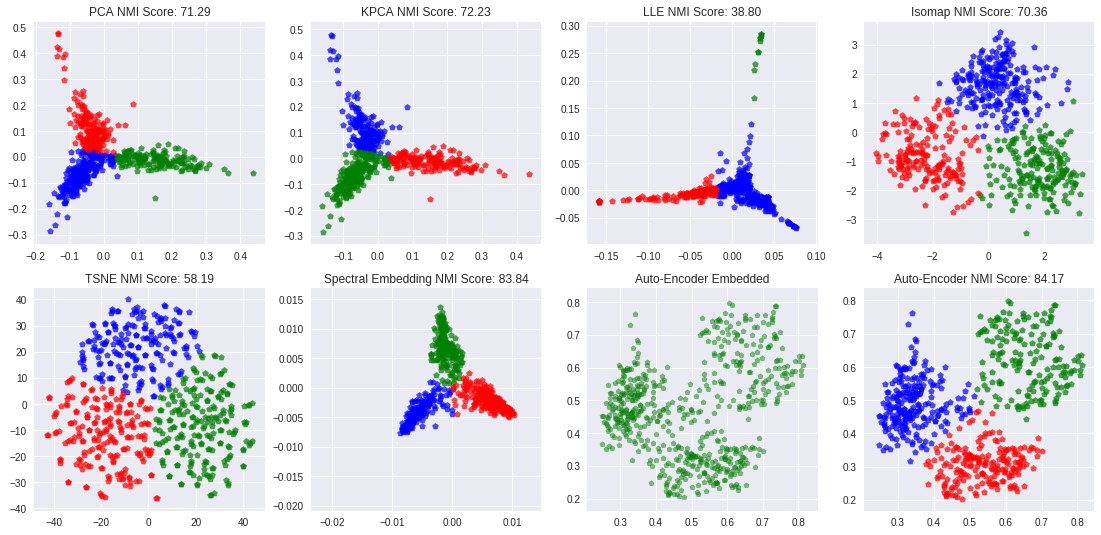

In [44]:
plt.figure(figsize=(19,9))
for num in range(n_groups):
  plt.subplot(2,4,1)  
  plt.scatter([X_pca[:,0][i] for i in range(len(pred_KMeans_pca)) if pred_KMeans_pca[i] == num],
              [X_pca[:,1][i] for i in range(len(pred_KMeans_pca)) if pred_KMeans_pca[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='p')
  plt.title(('PCA NMI Score: {:0.2f}').format(nmi_KMeans_pca*100))
  plt.subplot(2,4,2)
  plt.scatter([X_KPCA[:,0][i] for i in range(len(pred_KMeans_KPCA)) if pred_KMeans_KPCA[i] == num],
              [X_KPCA[:,1][i] for i in range(len(pred_KMeans_KPCA)) if pred_KMeans_KPCA[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='p')
  plt.title(('KPCA NMI Score: {:0.2f}').format(nmi_KMeans_KPCA*100))
  plt.subplot(2,4,3)
  plt.scatter([X_LLE[:,0][i] for i in range(len(pred_KMeans_LLE)) if pred_KMeans_LLE[i] == num],
              [X_LLE[:,1][i] for i in range(len(pred_KMeans_LLE)) if pred_KMeans_LLE[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='p')
  plt.title(('LLE NMI Score: {:0.2f}').format(nmi_KMeans_LLE*100))
  plt.subplot(2,4,4)
  plt.scatter([X_isomap[:,0][i] for i in range(len(pred_KMeans_isomap)) if pred_KMeans_isomap[i] == num],
              [X_isomap[:,1][i] for i in range(len(pred_KMeans_isomap)) if pred_KMeans_isomap[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='p')
  plt.title(('Isomap NMI Score: {:0.2f}').format(nmi_KMeans_isomap*100))
  plt.subplot(2,4,5)
  plt.scatter([X_tsne[:,0][i] for i in range(len(pred_KMeans_tsne)) if pred_KMeans_tsne[i] == num],
              [X_tsne[:,1][i] for i in range(len(pred_KMeans_tsne)) if pred_KMeans_tsne[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='p')
  plt.title(('TSNE NMI Score: {:0.2f}').format(nmi_KMeans_tsne*100))
  plt.subplot(2,4,6)
  plt.scatter([X_spec_embed[:,0][i] for i in range(len(pred_KMeans_spec_embed)) if pred_KMeans_spec_embed[i] == num],
              [X_spec_embed[:,1][i] for i in range(len(pred_KMeans_spec_embed)) if pred_KMeans_spec_embed[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='p')
  plt.title(('Spectral Embedding NMI Score: {:0.2f}').format(nmi_KMeans_spec_embed*100))
  plt.subplot(2,4,7)
  plt.scatter(ae_codes[:,0], ae_codes[:,1], 30, color='g', alpha=0.2, marker='p')
  plt.title('Auto-Encoder Embedded')
  plt.subplot(2,4,8)
  plt.scatter([ae_codes[:,0][i] for i in range(len(pred_KMeans_code)) if pred_KMeans_code[i] == num],
              [ae_codes[:,1][i] for i in range(len(pred_KMeans_code)) if pred_KMeans_code[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='p')
  plt.title(('Auto-Encoder NMI Score: {:0.2f}').format(nmi_KMeans_code*100))
plt.show()